In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../../..')

In [ ]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import scipy.stats as scist

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation

import tensorflow as tf

from IPython.display import HTML
from IPython.core.display import Markdown as md

from tqdm.notebook import tqdm, trange

import yfinance as yf

from analysis.fincalcs import log_returns
from analysis.options.pricing.phat import Phat, CarbenHybrid
from analysis.options.pricing.learn.utils import DataSplit, asymmactiv
from analysis.options.pricing.learn.phatnet import PhatBeta, PhatNet, BodyLoss, PhatLoss, PhatMetric
from analysis.options.pricing.learn.dists import Phat4TF
from analysis.options.pricing.bootstrap.numpy import dbl_bs

## Phat Fitness ##

Of course, as we now know, log daily returns on the S&P 500 are not Guassian ... or, at best, if they are Gaussian it means we are living in a one-in-$10^{100+}$ universe where a dozen or more six sigma events have occured in the past 100 years. Fans of the Many Worlds interpretation would agree this is entirely possible.

In our case, we will explore the fit of the Phat distribution, utilizing a network similar to that employed in Carreau (2009). We will first test our model against a generative version of Phat, with parameters chosen to mirror that of log daily S&P 500 returns.

In [3]:
args = [None, .0003, .0032, .17, .19]
genmod = Phat(*args)

n = 60000
y = genmod.rvs(size=n)
data = DataSplit(np.zeros(n), y)

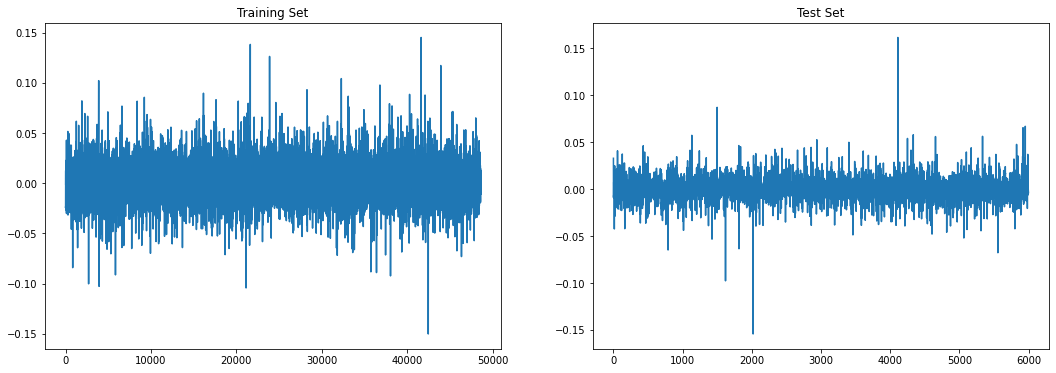

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
ax1.plot(data.train_raw.y)
ax2.plot(data.test_raw.y)

ax1.set_title('Training Set')
ax2.set_title('Test Set')
plt.show()

We developed a second custom network for this process, `PhatBeta`, containing a few key changes.

1. we have eliminated all but one hidden layer and reduced the nodes to just one. the input values are all zero and so their weighting is valueless. the bias from the hidden layer is the only meaningful input to the parameter layer.
2. the hidden layer has *no activation function*. the `x` values provided are all zero. Activating them does nothing.
2. we have added two additional parameters, `shape_l` and `shape_r`, representing the tail indices of the left and right-tailed Pareto distributions incorporated in the Phat distribution.
3. the loss function is now the negative log-likelihood of the Phat distribution
4. the `PhatMetric` class instantiates a metric for any one of the Phat parameters in the body and in both tails (side of tail must be specified).
4. a number of operations were pushed lower-level for convenience

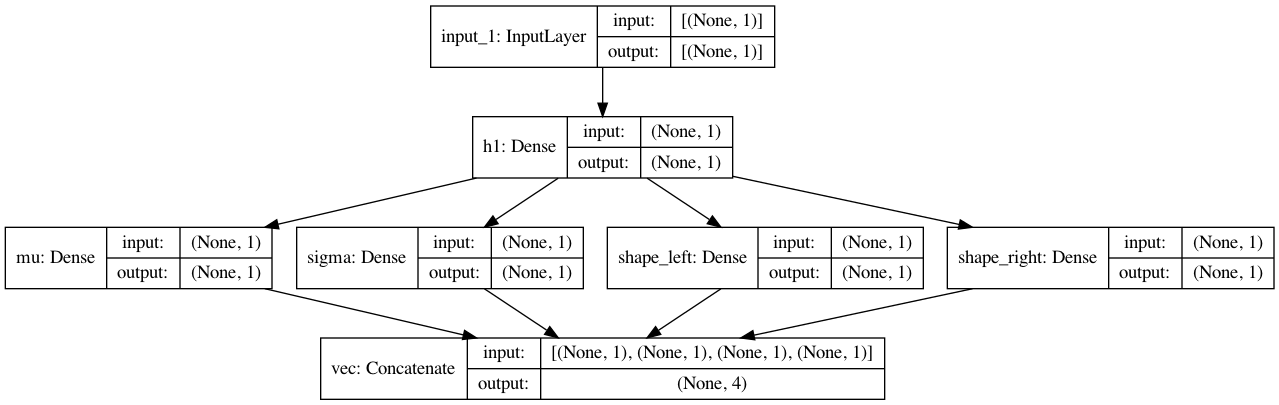

In [5]:
dn = PhatBeta(neurons=1)
dn.plot_model()

In [30]:
metrics = [
    PhatMetric('mean_left'), 
    PhatMetric('std_left'), 
    PhatMetric('shape_left'), 
    PhatMetric('shape_right'),
]
dn.compile(loss=BodyLoss(), optimizer='adam', metrics=metrics)
history = dn.fit(
    data.train, 
    validation_data=data.test,
    epochs=200, 
    batch_size=32, 
    verbose=1
)

Epoch 1/200
1519/1519 [==============================] - 7s 3ms/step - loss: -0.5185 - mean_left: 0.0010 - std_left: 0.0227 - shape_left: 0.0563 - shape_right: 0.1540 - val_loss: -2.2701 - val_mean_left: 0.0022 - val_std_left: 0.0226 - val_shape_left: 0.0562 - val_shape_right: 0.1538
Epoch 2/200
1519/1519 [==============================] - 4s 2ms/step - loss: -2.9382 - mean_left: 9.9299e-04 - std_left: 0.0041 - shape_left: 0.0119 - shape_right: 0.0267 - val_loss: -3.1661 - val_mean_left: 0.0011 - val_std_left: 0.0041 - val_shape_left: 0.0119 - val_shape_right: 0.0267
Epoch 3/200
1519/1519 [==============================] - 4s 2ms/step - loss: -3.1727 - mean_left: 8.2887e-04 - std_left: 0.0037 - shape_left: 0.0061 - shape_right: 0.0147 - val_loss: -3.1743 - val_mean_left: 7.4636e-04 - val_std_left: 0.0037 - val_shape_left: 0.0061 - val_shape_right: 0.0147
Epoch 4/200
1519/1519 [==============================] - 3s 2ms/step - loss: -3.1756 - mean_left: 8.7057e-04 - std_left: 0.0037 - sha

We can compare results with the generative model:

In [34]:
mean_, std_, shl_, shr_ = dn.predict([0])[0]
phat_fit = Phat(None, *dn.predict([0])[0])
pd.DataFrame(
    (genmod.args,phat_fit.args), 
    index=['Gen Model', 'Neural Net Fit'],
    columns=['mean', 'std', 
        r'$1/\alpha_{l}$', r'$loc_l$', r'$scale_l$',
        r'$1/\alpha_{r}$', r'$loc_r$', r'$scale_r$',
    ]
).T.style.format('{:.4f}')

,Gen Model,Neural Net Fit
mean,0.0003,0.0008
std,0.0032,0.0037
$1/\alpha_{l}$,0.1700,0.0000
$loc_l$,-0.0011,-0.0006
$scale_l$,0.0088,0.0100
$1/\alpha_{r}$,0.1900,0.0000
$loc_r$,0.0017,0.0021
$scale_r$,0.0088,0.0100


This approach was quite a poor fit, particularly in the tails where shape was essentially ignored. Below we can see why. We compare the change in the log-likelihood for chnages in teh parameters. Changes in the mean have a clear absolute minimum, changes in standard deviation are actually asymptotic to declining loss, and changes in the tail shapes are linearly across a very narrow range. So shape can be turned all the way down to zero with minimal impact.

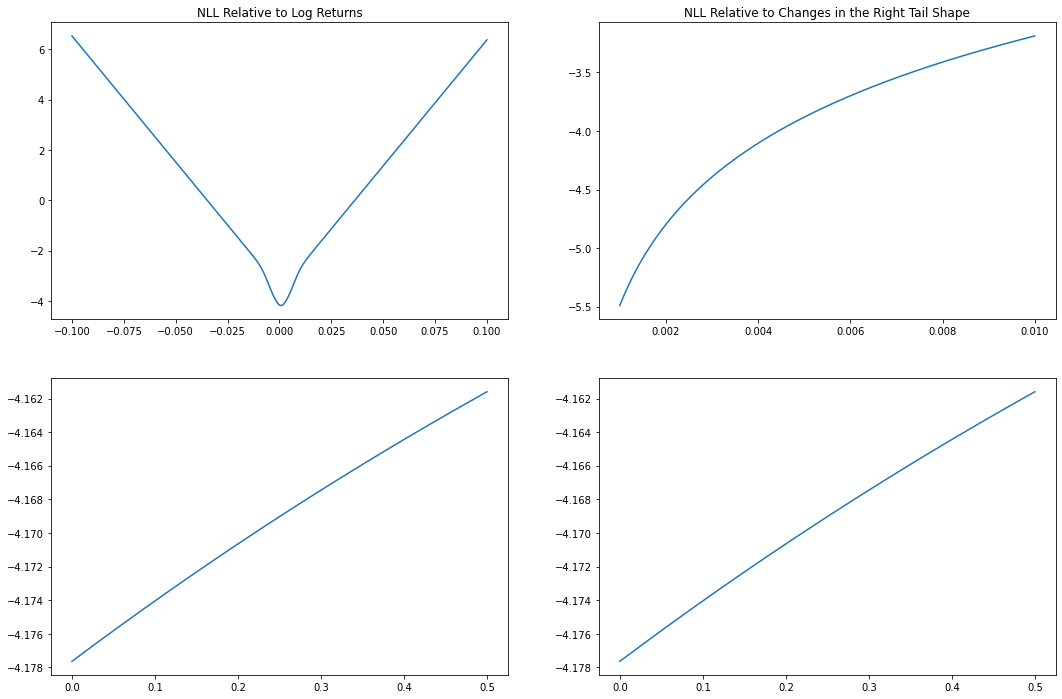

In [39]:
y = np.linspace(-.1, .1, 1000)
siglin = np.linspace(0.001, 0.01, 1000)
shlin = np.linspace(0, .5, 1000)

shl_pdf = [Phat(mean_, mean_, std_, sh, shr_).pdf() for sh in shlin]
shr_pdf = [Phat(mean_, mean_, std_, shl_, sh).pdf() for sh in shlin]

shl_nll = [Phat(mean_, mean_, std_, sh, shr_).nll() for sh in shlin]
shr_nll = [Phat(mean_, mean_, std_, shl_, sh).nll() for sh in shlin]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(y.reshape(-1,1), phat_fit.nll(np.tile(y, 1)).T)
ax2.plot(siglin.reshape(-1,1), Phat(mean_, mean_, siglin, shl_, shr_).nll().T)
ax3.plot(shlin, shl_nll)
ax4.plot(shlin, shr_nll)

ax1.set_title('NLL Relative to Log Returns')
ax2.set_title('NLL Relative to Deviation')
ax2.set_title('NLL Relative to Changes in the Left Tail Shape')
ax2.set_title('NLL Relative to Changes in the Right Tail Shape')

plt.show()

Below we confirm the normalized phat_ and the descaled params are in fact teh same distribution.

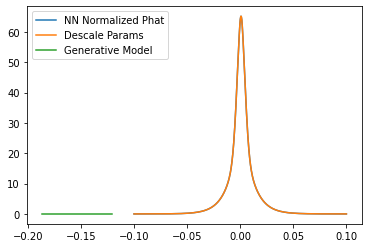

In [42]:
phatdes = Phat(None, mean_, std_, shl_, shr_)

x = np.linspace(-.1,.1,1000)

plt.plot(x, phat_fit.pdf(x).T, label='NN Normalized Phat')
plt.plot(x, phatdes.pdf(x).T, label='Descale Params')
plt.plot(data.descale(x), genmod.pdf(data.descale(x)).T, label='Generative Model')

plt.legend()
plt.show()

Below we can see the fix of `PhatBeta` versus the `Phat` generative model. It does appear `PhatBeta` is actually a better fit for the body of the model than the model itself, BUT we can how the gnerative model twists to become more dominant in the tails.

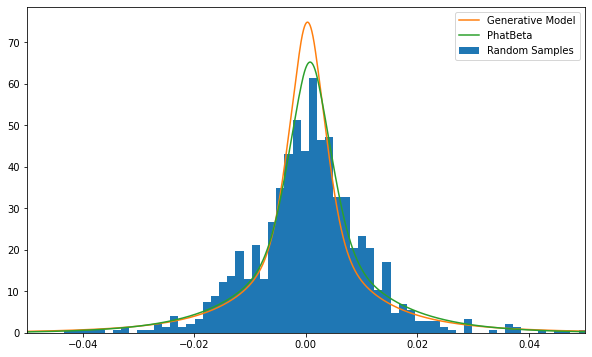

In [46]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

y = genmod.rvs(size=1000)
y_ = np.linspace(y.min(), y.max(), 10000)

bins = np.linspace(y.min(), y.max(), 100)
ax.hist(y, bins=bins, density=True, label='Random Samples')
ax.plot(y_, genmod.pdf(y_), label='Generative Model')
ax.plot(y_, phat_fit.pdf(y_), label='PhatBeta')

ax.set_xlim((-.05, .05))

ax.legend()
plt.show()

## Tail Quest ##

For now, we incorporate $\xi$ as found via HDB as one of those dreaded outside estimators, considered the truthful value. Theoretically, however, the method could be incorporated within a neural network and its additional parameters trained as a result.

The problem of underestimating the tails results from the limited number of occurences of tail events. We saw in the charts above that the impact of the tail index size on the probability distribution is negligble, owing again to their relatively low likelihood of occurence.

A single tail event at this tail index level barely influences the mean and it is highly unlikely for anymore than 1-2 tail events to show up in a batch and so the model never receives a significant push towards a truer mean, settling instead for the global minimum when the tail index is eliminated.

We should emphasize this is *only* for this tail index level, say, $\xi < .5$. At higher index values, the tail events are actually so impactful that they result in indefinite variance and at some point even an indefinite mean.

Obviously, some kind of tail loss must be incorporated in order to better fit the model in the tails. Carreau (2009) does not directly address the issue from the perspective of an independent variable. They use comparative loss analysis with tail estimators (a set of extreme quantiles) derived either from their generative model or non-parametric methods. Similarly, throughout the literature are many examples of having to fit the tails relative to some third participant ... effectively, in order to estimate the tail using NN, one must first estimate the tail some other way.

There has been much study on the problem of estimating the tail index. So much so that one paper catalogued literally [100+ estimators](https://mpra.ub.uni-muenchen.de/90072/1/MPRA_paper_90072.pdf).

We previously outlined the manual process of Peak Over Threshold (POT). The Hill Estimator is another popular approach particularly useful for Pareto distributions, defined as:

$$
\alpha_{n,\kappa} = {\kappa}\left[\sum\limits_{i=1}^{\kappa}log\frac{x_{i}}{x_{\kappa+1}}\right]^{-1}
$$

where: $x_i$ is an i.i.d. descending ordered statistic such that $x_1 >= x_2 ... >= x_n$

This can be reframed in terms of $\xi$ from the Extreme Value and Generalized Pareto Distributions as:

$$
\xi_{n,\kappa} = \frac{1}{\kappa}\sum\limits_{i=1}^{\kappa}log\frac{x_{i}}{x_{\kappa+1}}
$$

where: $$\xi = \frac{1}{\alpha}$$

The log of a Pareto is understood to be exponential, so this is essentially the exponential first moment calculation for every $\kappa th$ largest sample where the $\kappa th$ sample is assumed to be the true location parameter.

The Hill Estimator is known to be [asymptotically stable](https://projecteuclid.org/journals/annals-of-statistics/volume-28/issue-1/How-to-make-a-Hill-plot/10.1214/aos/1016120372.full) for certain Pareto distributions. We can see this, for instance, with Pareto Type-I below.

In [23]:
def hill_est_for_alpha(k, y):
    return k / (np.cumsum(np.log(y[:-1])) - k*np.log(y[1:]))

def hill_est_for_xi(k,y):
    return np.cumsum(np.log(y[:-1]))/k - np.log(y[1:])

In [24]:
n = 10000
a, x_m= 5, 5
par = scist.pareto(a, loc=x_m)
y = par.rvs(size=n)
y = np.sort(y)[::-1]
y = y - x_m
k = np.arange(1,n)
par_hill = hill_est_for_alpha(k,y)

(0.0, 10.0)

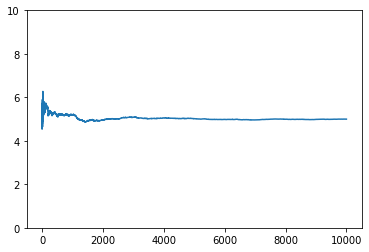

In [25]:
plt.plot(par_hill)
plt.ylim(0,10)

Using a Generalized Pareto parameterized equivalent to a Pareto-I results in the same clear asymptote at the expected value.

In [26]:
n = 10000
xi = 1/a
scale = x_m*xi
loc = scale / xi
gp = scist.genpareto(xi, loc=loc)
y = gp.rvs(size=n)
y = np.sort(y)[::-1]
k = np.arange(1,n)
hill_gp = hill_est_for_xi(k,y)

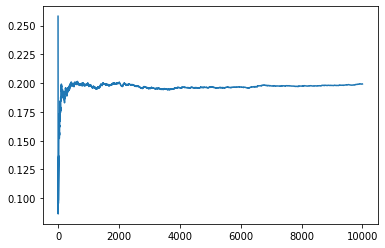

In [27]:
plt.plot(hill_gp)
plt.show()

Any deviation from the Pareto equivalence, however, makes the Hill estimator less valuable. As per below plot below, there is no obvious asymptote or stable value maintained for any region of $\kappa$.

In [28]:
n = 10000
xi = 1/a
scale = .02
loc = 1/4
gp = scist.genpareto(xi, loc=loc)
y = gp.rvs(size=n)
y = np.sort(y)[::-1]
k = np.arange(1,n)
hill_gp2 = hill_est_for_xi(k,y)

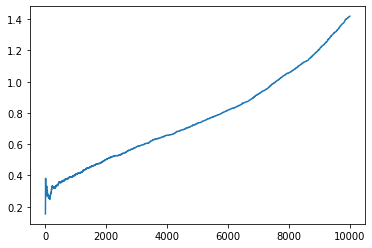

In [29]:
plt.plot(hill_gp2)
plt.show()

And, of course, similar behavior is shown in the above-mean values of the S&P 500 returns.

In [30]:
sp = yf.download('^GSPC')
sp_lret = log_returns(sp.Close)

pos = sp_lret[sp_lret > sp_lret.mean()]
pos = np.sort(pos)[::-1]

k = np.arange(1, pos.shape[0])
hill_sp = hill_est_for_xi(k, pos)

[*********************100%***********************]  1 of 1 completed


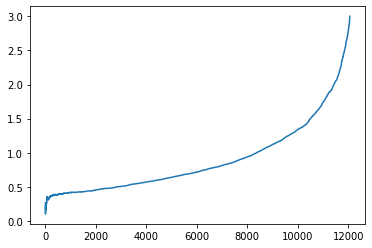

In [31]:
plt.plot(hill_sp)
plt.show()

The Hill Double Bootstrap is one quantitative approach that narrows in on a valid tail index estimate when one is not evident visually. The technique is outlined by [Voitalov (2019)](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.1.033034) building on [Danielsson (2001)](https://www.sciencedirect.com/science/article/pii/S0047259X00919031).

The approach is based on a quantity known as the Asymptotic Mean Squared Error, AMSE, defined as:

$$\text{AMSE}(n, \kappa) = E[(\hat{\xi}_{n, \kappa} - \xi)^2]$$

In this definition, we still have the issue of the unknown truth value $\xi$. The Hill Double Bootstrap replaces the truth value with a second estimator, so that:

$$
\text{AMSE}(n, \kappa) = E[(\hat{\xi}^{(2)}_{n_1, \kappa_j} - \hat{\xi}^{(1)}_{n_2, \kappa_j})^2]
$$

where $\hat{\xi}^{(1)} \text{and } \hat{\xi}^{(2)}$ are found via the first and second moments of the tail index of the sample (with the first moment being the Hill estimator), resulting in:

$$
\text{AMSE}(n, \kappa) = E[(M_2 - 2M_1^2)^2]
$$

The goal of the Hill Double Bootstrap is for the two estimators to converge, with their convergence value being the true value. The procedure is as follows:

1. Repeat $r$ number of iterations through the data, drawing $n_1$ samples for each iteration.
2. For each $\kappa$ in $n_1$, find the first estimator, the Hill estimate which is the sample's first moment:
$$
M_{1,\kappa_1} = \frac{1}{\kappa_1}\sum\limits_{i=1}^{\kappa}ln\frac{x_i}{x_{k+1}}
$$
3. For each $\kappa$ in $n_1$, find the second estimator, which is derived from the sample's second moment: 
$$
M_{2,\kappa_1} = \frac{1}{\kappa_1}\sum\limits_{i=1}^{\kappa}(ln\frac{x_i}{x_{k+1}})^2
$$
4. Find $\kappa_1^*$ that minimizes 
$\frac{1}{r}\sum\limits_{j=1}^r(M_{2,\kappa_1} - 2(M_{1,\kappa_1})^2)^2$ 
*(adjustment applied to $M_1$ as it has a different multiplicative constant)*

5. Repeat 1. thru 4. with a second sample of size $n_2$ and find $\kappa_2^*$
6. Find $\kappa^* = A(\kappa_1^*, n_1, n)\frac{(\kappa_2^*)^2}{\kappa_1^*}$
7. Then, the tail index is $\xi = M_1,{\kappa^*}$

where:
$
r: \text{number of bootstrap samples}
\\t \in [0,1]: \text{proportion between bootstrap sample sizes}
\\n_1 = \sqrt{t}n
\\n_2 = tn
\\\kappa_i = 1 ... n_i
$

$A(.)$ has a non-trivial derivation outlined in Daniellson (2001) as Corollary 7. Voitalov (2019) also points to a different factor arrived at by [Qi (2008)](https://link.springer.com/article/10.1007%2Fs10687-007-0049-8).

We will demonstrate the process for both tails of a random sample from the Phat distribution.

1. Begin by creating a generative model Phat distribution and generating a set of random samples. 
2. Isolate samples in the right tail. We will cutoff the data at the sample mean and not the right tail location as technically this location should be an unknown.
3. Sort the remaining samples from descending order.
4. Define several parameters consistent with Voitalov (2019).

In [71]:
genmod = Phat(None, .0003, .0032, .25, .18)
data = genmod.rvs(size=100000)
y = data[data>=data.mean()]
y = np.sort(y)[::-1]

In [72]:
r = 500
t = .5
n = y.size
n1 = int(np.sqrt(t)*n)
n2 = int(t*n)
k = np.arange(1, y.size)

Our first order of business is to find the Hill estimate at each $\kappa$ for the entire dataset. We already have a function for this.

In [73]:
xi = hill_est_for_xi(k,y)

In the plot, we see the familiar exploding tail.

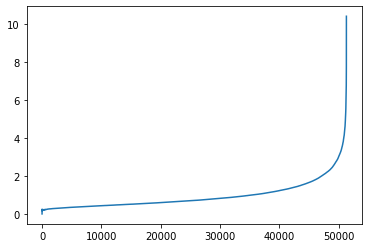

In [74]:
plt.plot(xi)
# plt.xlim(0,10000)
# plt.ylim(0,1)
plt.show()

Now we implement the iterative process through $r$ for sample size $n_1$:

For r iterations:

1. Pull $n_1$ samples from the data.
2. Sort the samples in ascending order
3. Find the first moment, $M1$ (the Hill estimator), and second moment, $M2$.
4. Find the AMSE between the two moment estimators.

After iterating:

5. Find the mean of the accumulated errors in each $\kappa$ across the $r$ iterations
6. $\kappa*$ is the index of the minimum mean AMSE

In [75]:
def second_moment(k, y):
    t1 = np.cumsum(np.log(y[:-1])**2) / k 
    t2 = 2*np.cumsum(np.log(y[:-1]))*np.log(y[1:]) / k
    t3 = np.log(y[1:])**2
    return t1 - t2 + t3

def amse(M1, M2):
    return (M2 - 2*M1**2)**2

In [76]:
def third_moment(k,y):
    """
    """
    t1 = (1/k)*np.cumsum(np.log(y[:-1])**3)
    t2 = (3*np.log(y[1:])/k)*np.cumsum(np.log(y[:-1])**2)
    t3 = (3*np.log(y[1:])**2/k)*np.cumsum(np.log(y[:-1]))
    t4 = np.log(y[1:])**3
    M3 = t1 - t2 + t3 - t4
    return M3

In [116]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

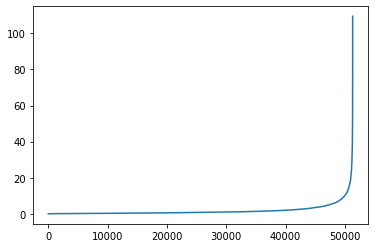

In [78]:
plt.plot(second_moment(k,y))
# plt.xlim(-10,1000)
# plt.ylim(0,1)
plt.show()

In [98]:
import warnings

In [100]:
i_kmin = 1
i_kmax = (np.abs(np.linspace(1./n1, 1.0, n1) - 1)).argmin()
amses = np.zeros((r, n1-1))
for i in range(r):
    sample = np.random.choice(y, n1, replace=True)
    sample = np.sort(sample)[::-1]
    k = np.arange(1,n1)
    M1 = hill_est_for_xi(k,sample)
    M2 = second_moment(k,sample)
    amses[i] = amse(M1,M2)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    amse_for_k = np.nanmean(amses, axis=0)

k1 = np.nanargmin(amse_for_k[i_kmin:i_kmax]) + 1 + i_kmin
k1

242

Next we repeat the iterative process through $r$ for sample size $n_2$. The process is encapsulated in the `k_finder` function.

In [101]:
from analysis.options.pricing.bootstrap.numpy import k_finder

k2 = k_finder(y, n2, r, 1)
k2

166

Note one implication of the procedure above is the assumption of `k_min=1`. If $\kappa_2 > \kappa_1$, this may be evidence that the assumption is incorrect. So the `r` iterative process for each $\kappa$ is repeated until $\kappa_2 <= \kappa_1$ as outlined in Voitalov (2019).

In [102]:
kmin1, kmin2 = 1,1
while True:
    k1 = k_finder(y, n1, r, kmin1)
    k2 = k_finder(y, n2, r, kmin2)

    if k2 > k1:
        kmin1 += int(0.005*n)
        kmin2 += int(0.005*n)
    else:
        break

We now find our $\kappa^*$ as $A(\kappa_1^*, n_1, n)\frac{(\kappa_2^*)^2}{\kappa_1^*}$. As noted in Voitalov (2019), A(.) has a couple of formulas. We use the Qi formulation here, but Daniellson is also avialable.

In [103]:
from analysis.options.pricing.bootstrap.numpy import A_qi

In [104]:
k_star = A_qi(n1,k1)*k1**2 / k2
k_star = np.round(k_star).astype(int)
xi[k_star]

0.244032451162858

We can see the estimate is failry close to the actual value utilized. 

We can repeat this process for the left tail, this time using the `dbl_bs` function which encapsulates the above process. When examining the left tail, we simply have to negate the values.

In [105]:
import itertools as it
from tqdm.notebook import tqdm, trange
from analysis.options.pricing.bootstrap.numpy import dbl_bs

In [106]:
y_left = data[data<data.mean()]
y_left = np.sort(-y_left)[::-1]

xi_star = dbl_bs(y_left, t=.5, r=500, style='hill', A_type='qi')
xi_star

0.2870556868538827

Once again we have decent agreement with the actual tail

In [107]:
ts= np.linspace(.1, .8, 5)
rs = np.array([100, 250, 500, 1000, 2500])
results = []
for t, r in tqdm(it.product(ts, rs), total=ts.size*rs.size):
    for i in trange(4, leave=False):
        xi_left = dbl_bs(y_left, t=t, r=r, style='hill', A_type='qi')
        xi_right = dbl_bs(y, t=t, r=r, style='hill', A_type='qi')
        res = {}
        res['t'] = t
        res['r'] = r
        res['xi_left'] = xi_left
        res['xi_right'] = xi_right
        results.append(res)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
df = pd.DataFrame(results)
df.to_csv('dbs_test_on_r_and_t.csv')
# df = pd.read_csv('dbs_test.csv')

In [65]:
df_avg = pd.DataFrame(df.values.reshape(-1, 4, df.values.shape[1]).mean(axis=1), columns=df.columns)

AttributeError: 'DataFrame' object has no attribute 'left_err_per'

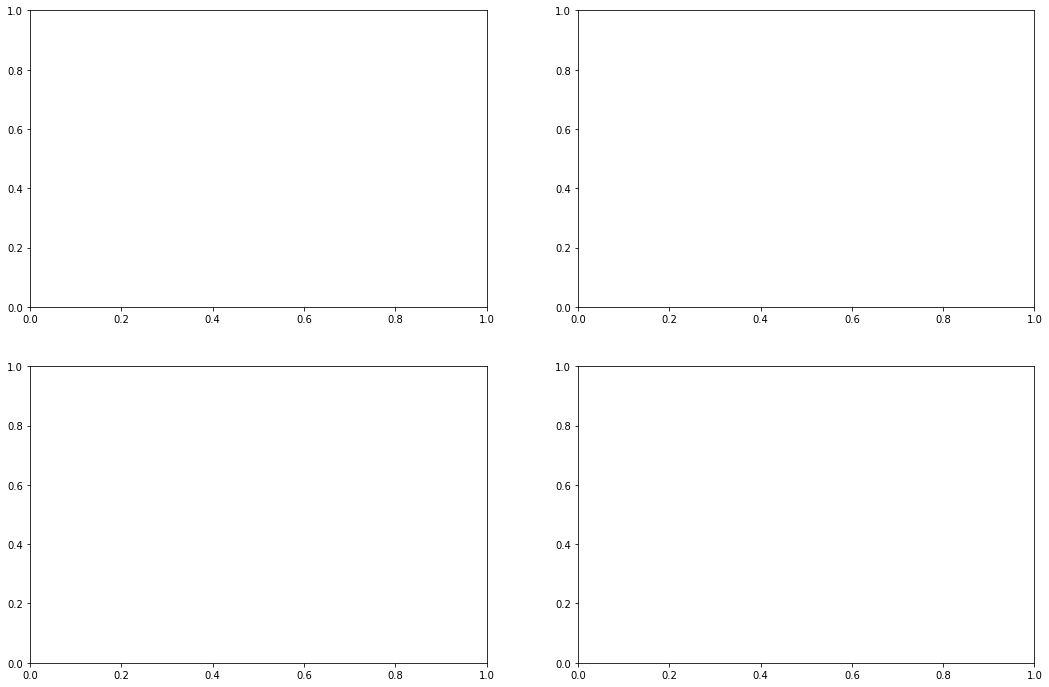

In [66]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.scatter(df_avg.xi_lactual, df_avg.left_err_per, label='Left Tail')
ax1.scatter(df_avg.xi_ractual, df_avg.right_err_per, label='Right Tail')
ax1.set_xscale('log')
ax1.set_xticks([.1, .25, .5, 1, 2.5, 5])
ax1.set_xticklabels([.1, .25, .5, 1, 2.5, 5])


ax2.scatter(df_avg.n, df_avg.left_err_per, label='Left Tail')
ax2.scatter(df_avg.n, df_avg.right_err_per, label='Right Tail')
ax2.set_xscale('log')

ax3.scatter(df_avg.left_err_per, df_avg.right_err_per)
ax3.axvline(0, c='C3', ls='--', alpha=.5)

plt.show()

In [546]:
results = []
ns = np.logspace(3.75,5.35,5).astype(np.int)
tails = np.array([.1,.2,.35, .5, 1, 2.5, 5])

loop = it.product(ns, it.product(tails, tails))
try:
    for n, xi in tqdm(loop, total=ns.size*tails.size):
        genmod = Phat(None, .0003, .0032, *xi)
        data = genmod.rvs(size=n)
        y_left = data[data<0]
        y_left = np.sort(-y_left)[::-1]
        y_right = data[data>0]
        y_right = np.sort(y_right)[::-1]
        for i in trange(4, leave=False):
            xi_lest = dbl_bs(y_left, t=.5, r=500, style='hill', A_type='qi')
            xi_rest = dbl_bs(y_right, t=.5, r=500, style='hill', A_type='qi')
            res = {}
            res['t'] = .5
            res['r'] = 500
            res['n'] = n
            res['mean'] = data.mean()
            res['xi_lactual'], res['xi_ractual'] = xi
            res['xi_lest'] = xi_lest
            res['xi_rest'] = xi_rest
            results.append(res)
except Exception as e:
    print (n, np.sqrt(t)*n, t*n, xi[0], xi[1], .5, 500)
    raise e

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [108]:
# df = pd.DataFrame(results)
# df.to_csv('dbs_test_on_sample_size_and_tails.csv')
df = pd.read_csv('dbs_test_on_sample_size_and_tails.csv')

In [109]:
df['left_err'] = df.xi_lactual - df.xi_lest
df['right_err'] = df.xi_ractual - df.xi_rest
df['left_err_per'] = df['left_err'] / df.xi_lactual
df['right_err_per'] = df['right_err'] / df.xi_ractual

In [110]:
df_avg = pd.DataFrame(df.values.reshape(-1, 4, df.values.shape[1]).mean(axis=1), columns=df.columns)

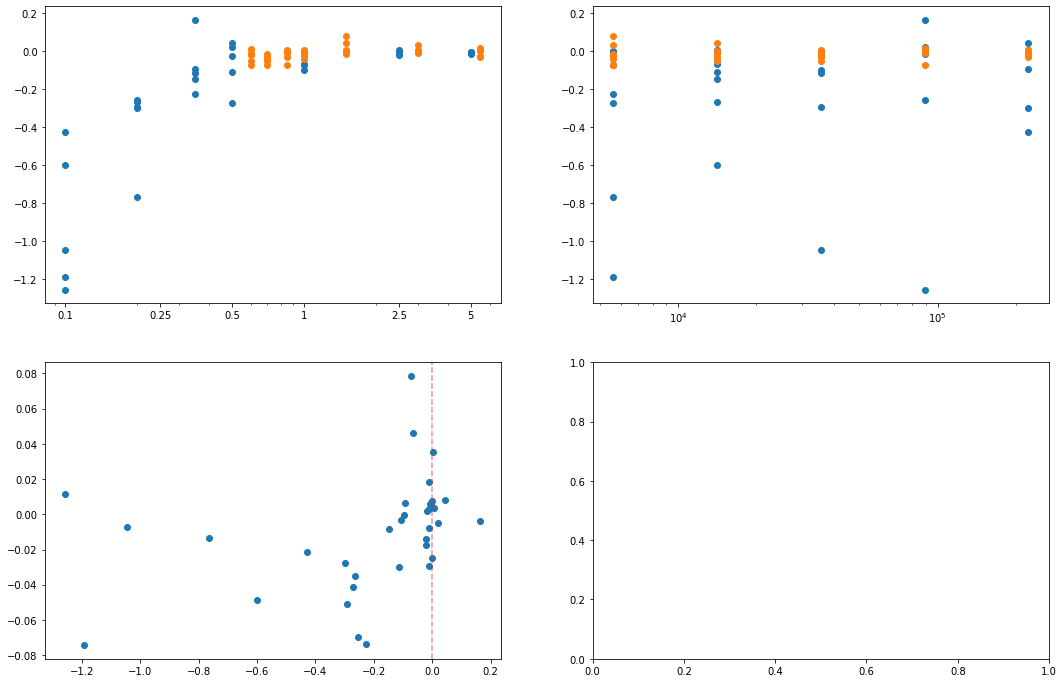

In [111]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.scatter(df_avg.xi_lactual, df_avg.left_err_per, label='Left Tail')
ax1.scatter(df_avg.xi_ractual, df_avg.right_err_per, label='Right Tail')
ax1.set_xscale('log')
ax1.set_xticks([.1, .25, .5, 1, 2.5, 5])
ax1.set_xticklabels([.1, .25, .5, 1, 2.5, 5])


ax2.scatter(df_avg.n, df_avg.left_err_per, label='Left Tail')
ax2.scatter(df_avg.n, df_avg.right_err_per, label='Right Tail')
ax2.set_xscale('log')

ax3.scatter(df_avg.left_err_per, df_avg.right_err_per)
ax3.axvline(0, c='C3', ls='--', alpha=.5)

plt.show()

### CAVEAT ###

One assumption required for the Hill Double Bootstrap is that the regularly varying distribution of the samples satisfies the second-order condition and the generalized Pareto does *not*. See [Voitalov (2019)] for a discussion of this. Voitalov sees the consistent convergence of the method to the true tail as evidence that some other as yet unknown property of the Pareto allows for this method.

estimate inline with many other reviews. below shows tail index estimators for various markets, argues index is consistent globally, shows left tail appears fatter but difference not significant

file:///Users/spindicate/Downloads/SSRN-id291399.pdf



In [1]:
wude variability in tail index estimation among different methods
https://www.riskresearch.org/files/DanielssondeHaanErgundeVries2016.pdf

SyntaxError: invalid syntax (<ipython-input-1-d765c4b5dc31>, line 1)

De Vries at least first two moment sexist
# https://www.jstor.org/stable/2109682

greater the tail risk, greater the impact on return
https://researchrepository.wvu.edu/cgi/viewcontent.cgi?article=4985&context=etd

Daily returns alpha > 2 but low degree of certainty
# https://watermark.silverchair.com/003465397556755.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAqcwggKjBgkqhkiG9w0BBwagggKUMIICkAIBADCCAokGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM6GyoheKNc0JZ46NpAgEQgIICWrlXcdFpqtuQqp9oG31eA4pvS_LfOUqwEQn-_YhlhyczO8R7H99_Lg-xt0uQTyXAD8SSSFXSlVh6siw2fUWKThBpebPyfmu0PhFiK4S3OCYszObwV8pT-SsJ6Hf35JRUIv1ExlsNNIRfjWIskCYZjAt9XqvpakeDTPcezScjV7o-9VJ8pMT53HJ_By8p5G4E-MBbBLs5k3IiFuNibO--QZmbpQZaSKB4_KBCkcJJvMtMFhosZx5VykZcLl0ORwqptsSktK-7CRRJv5CXfEdwJbjAZUHCHcHcrpqb80iqqn_0B5kApnnoSWCgo3sJpFt_rSj5XH-q1BY72zfYk1gqU7T5P-iTTpOrVo0QfpgOxOiwXr1kd_yyK8Z9JoZ4DerumHp8eW05JYJ6r0Zn3NoNJHOVOtsr2POUXkmn8wP8fxkhRzjWGdXgoPP22ShHZmzda8z5VGa2TOKjMAk4iG5ah8tQw3nE1FVAxuLhQzgYANNfEUmLn3NyODqBdizDtdxMe4bNpY07Oh1tBy-NwbQMQs8QCjZH5kYJkNz-F4wXCfU7JrxvQObDToo1XOkOrrh6ahhQH_l_30kTQJgwuWSzkM3lBzL1Kwmj5M_tX8JFPQQZ5zjnRJrz4DzIpmcBV1LipBxAjsgyJ9kfBhqZDDApWoY-txD59rTeK6VnF_HIUFmMUIdHS99JlHkmxgzy4TmdJWCvuQWoMdcvGFrQwPVum8fCFMXPIDJU6nSKoCVsHOUmw8Dkcpm2eamv6tZZFCdbJYqVRcI-id2rAcPA51r-zv_nmHifNzQaixqr

## Fitting With Tails ##

Now we have a method for estimating the tail index of both tails of our Phat distribubtion and that estimate can be used to alleviate the issue of overfitting in the tails of our neural network.

To do so, we have to amend the network model as outlined previously including our custom loss function. The updated network is available as `PhatNet`.

First, we will generate some data.

In [112]:
args = [None, .0003, .0032, .25, .29]
genmod = Phat(*args)

n = 60000
y = genmod.rvs(size=n)
data = DataSplit(np.zeros(n), y)

Then, we will find our estimate of each tail index.

In [113]:
y_left = y[y<y.mean()]
y_left = np.sort(-y_left)[::-1]
y_right = y[y>y.mean()]
y_right = np.sort(y_right)[::-1]

shl = np.zeros(10)
shr = np.zeros(10)
for i in trange(10):
    shl[i] = dbl_bs(y_left, t=.5, r=500, style='hill', A_type='dani')
    shr[i] = dbl_bs(y_right, t=.5, r=500, style='hill', A_type='dani')

  0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
shl.mean(), shr.mean()

(0.26415889141333687, 0.3338945277441968)

For our neural net, we want to train the shape parameters against our bootstrapped estimates and the remaining parameters against our Phat distribution. This means we must employ two different loss functions:

1. For each of the shape parameters, we use the asymptotic error discussed earlier, however, we take the log of both values to create a more valuable gradient (same concept as log-likelihood): 

    $$\text{AMLSE} = E[(log\hat{\xi} - log\xi)^2]$$

where: $\xi$ is now the estimate derived from the double bootstrap method and $\hat{\xi}$ is the value resulting from the gradient descent.

The AMSE of the left and right tails is then averaged.

2. For the body params $mu$ and $\sigma$, we will continue to use the negative log-likelihood of the resulting Phat distribution. Note this means the ongoing shape parameters must also be provided to the $mu$ and $sigma$ loss calculation.

We then combine these two losses, at each step, into a single loss driver according to the formula:

$$ \text{Loss} = \frac{\text{Loss}_{\textit{body}}}{\text{Loss}_{\textit{tail}}+1}$$

I must admit the above relationship was established solely via empiricism. As we'll see, it produces a loss curve that scales the relative importance of both the Body and Tail losses and allows for asymptotic behavior in either without negating it in the other. The addition of one avoids a zero asymptote in the denominator, thus avoiding exponential decline in the total loss as the AMLSE approaches zero. 

I am sure a more efficient combination could be formally derived but this seems to produce good convergence.

Below we can see the surface of the resulting loss function in terms of its constituents, the log-likelihood of the Phat distribution and the average of the AMLSE of each tail index.

<IPython.core.display.Javascript object>


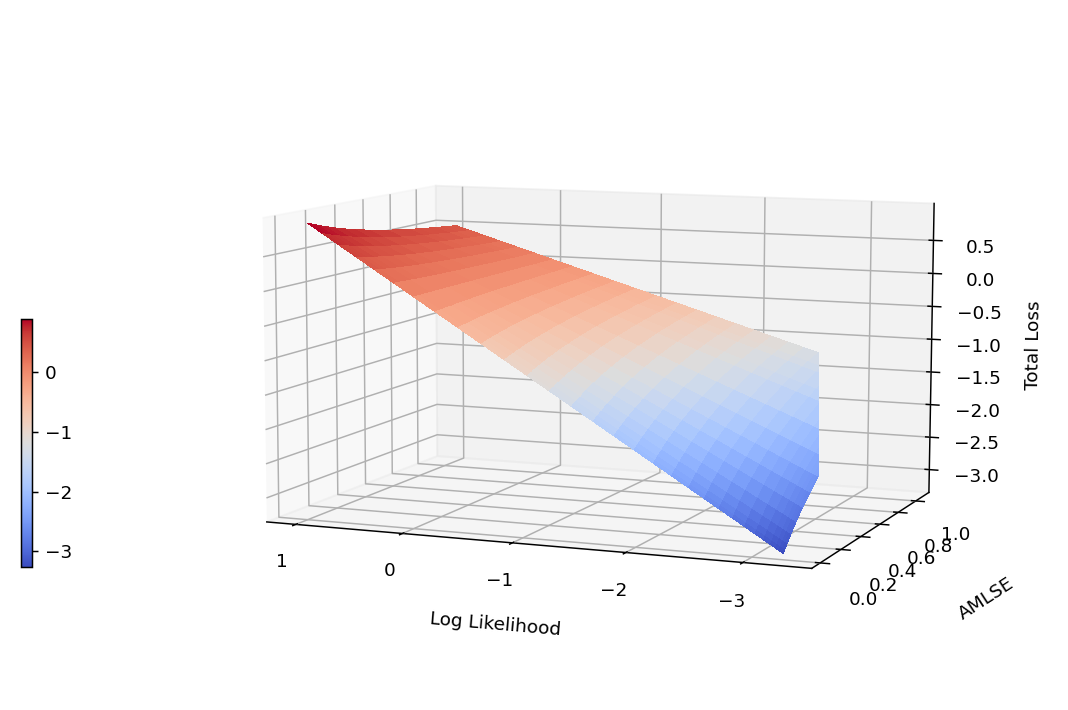

In [26]:
%matplotlib notebook
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(6,4),subplot_kw={"projection": "3d"})

history = pd.read_csv('history_phat_learning.csv')
bodyloss = history.nll
tailloss = history.two_tailed_amlse
X, Y = np.meshgrid(bodyloss, tailloss)
Z = X / (Y + 1)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=5, antialiased=False)

plt.gca().invert_xaxis()

ax.set_xlabel('Log Likelihood', labelpad=10)
ax.set_ylabel('AMLSE', labelpad=10)
ax.set_zlabel('Total Loss')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.75, 1.25, 1.25, 1.1]))

cax = fig.add_axes([0.02, .2, 0.01, 0.35])
fig.colorbar(surf, cax=cax, orientation='vertical')

plt.show()

Here we see the model.

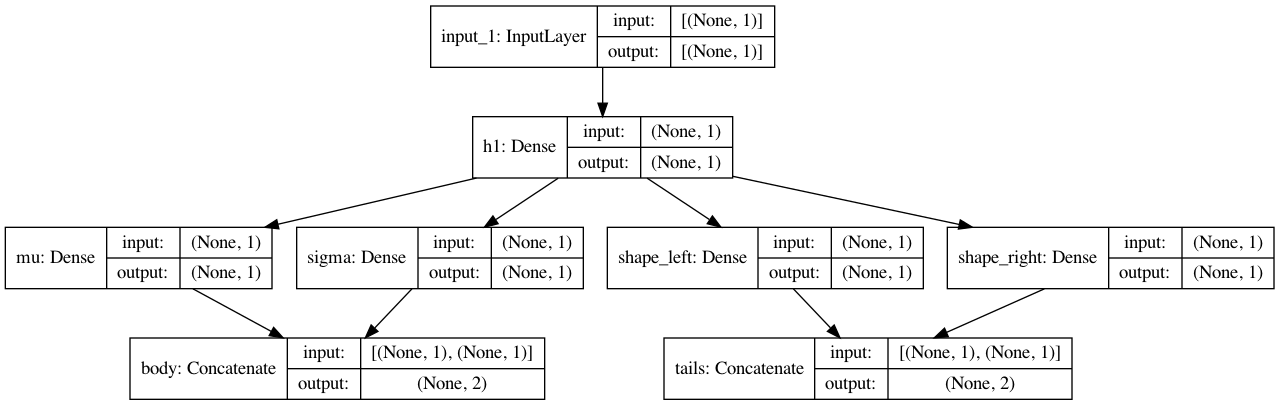

In [118]:
from analysis.options.pricing.learn.phatnet import PhatNet

nnet = PhatNet(neurons=1)
nnet.plot_model()

To compile the model, we pass our custom loss function `PhatLoss` as well as a number of custom metrics to monitor results, mainly through the `PhatMetric` class. Both `PhatLoss` and `TwoTailedAMLSE` take the estimated shape parameters as arguments.

In [119]:
metrics = [
    PhatMetric('loc_left'), 
    PhatMetric('loc_right'),
    PhatMetric('shape_left'),
    PhatMetric('shape_right'),
    PhatMetric('scale_left'),
    PhatMetric('scale_right'),
    PhatMetric('mean_left'),
    PhatMetric('std_left'),  
]
optimizer = tf.keras.optimizers.Adam(learning_rate=1*10**-4)
nnet.compile(loss=PhatLoss(shl.mean(),shr.mean()), optimizer=optimizer, metrics=metrics)

We have added some customization to the `fit` method including a number of callbacks. For instance, a TensorBoard log is created simply by passing the `logdir` keyword.

In [33]:
history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    logdir=f"logs-{dt.now().strftime('%Y-%m-%d')}"
)

Epoch 1/500
1519/1519 [==============================] - 8s 3ms/step - loss: 0.5079 - loc_left: -0.3467 - loc_right: 0.3132 - shape_left: 0.9107 - shape_right: 0.6170 - scale_left: 1.7059 - scale_right: 1.6340 - mean_left: 0.0037 - std_left: 0.5593 - val_loss: 0.4255 - val_loc_left: -0.3467 - val_loc_right: 0.3132 - val_shape_left: 0.9108 - val_shape_right: 0.6169 - val_scale_left: 1.7056 - val_scale_right: 1.6337 - val_mean_left: 0.0037 - val_std_left: 0.5592
Epoch 2/500
1519/1519 [==============================] - 4s 2ms/step - loss: 0.3404 - loc_left: -0.2890 - loc_right: 0.2320 - shape_left: 1.1778 - shape_right: 0.5769 - scale_left: 1.3447 - scale_right: 1.2312 - mean_left: 0.0019 - std_left: 0.4239 - val_loss: 0.2575 - val_loc_left: -0.2890 - val_loc_right: 0.2320 - val_shape_left: 1.1779 - val_shape_right: 0.5769 - val_scale_left: 1.3445 - val_scale_right: 1.2309 - val_mean_left: 0.0019 - val_std_left: 0.4238
Epoch 3/500
1519/1519 [==============================] - 4s 2ms/step -

In [46]:
results = pd.DataFrame(
    list(zip(nnet.predicted_params('values'), genmod.learnable_params)),
    index=genmod.PARAM_NAMES[:4],
    columns=['Trained', 'Actual']
)
results

,Trained,Actual
mean,0.000792,0.0003
std,0.003654,0.0032
shape_l,0.268800,0.2500
shape_r,0.270340,0.2900


## Caution on Scaling ##

The model inputs are all `0` so the usual concerns regarding normalization/standardization/activation in the hidden layer do not apply. Still, the scale of the `y` values that are our targets do impact performance in an important way.

If the scale of the `y` values is too large, our custom loss function will work in the exact opposite fashion we expect. To see why, recall our loss function:

$$ \text{Loss} = \frac{\text{Loss}_{\textit{body}}}{\text{Loss}_{\textit{tail}}+1}$$

We can see that if $\Delta \text{Loss}_{\textit{tail}} >>> \Delta\text{Loss}_{\textit{body}}$, then an *increase* in both will lead to a decreasing loss value.

This can result if the scaling of `y` is too large. 

To demonstrate, we'll repeat the prior experiment and simply increase the standard deviation for of the normal portion of our Phat distribution by a factor of 100.

In [120]:
args = [None, .0003, .32, .25, .29]
genmod = Phat(*args)

n = 60000
y = genmod.rvs(size=n)
data = DataSplit(np.zeros(n), y)

In [121]:
y_left = y[y<y.mean()]
y_left = np.sort(-y_left)[::-1]
y_right = y[y>y.mean()]
y_right = np.sort(y_right)[::-1]

shl = np.zeros(10)
shr = np.zeros(10)
for i in trange(10):
    shl[i] = dbl_bs(y_left, t=.5, r=500, style='hill', A_type='dani')
    shr[i] = dbl_bs(y_right, t=.5, r=500, style='hill', A_type='dani')

  0%|          | 0/10 [00:00<?, ?it/s]

In [122]:
shl.mean(), shr.mean()

(0.23197785780235755, 0.25097221813636506)

Note that the tail estimates are essentially unchanged. The tail index is not ultimately impacted by changes in the body. The location of each tail will be impacted, but not index.

In [123]:
from analysis.options.pricing.learn.phatnet import PhatMetric, NLL, TwoTailedAMLSE

metrics = [
    NLL(),
    TwoTailedAMLSE(shl.mean(), shr.mean()),
    PhatMetric('loc_left'), 
    PhatMetric('loc_right'),
    PhatMetric('shape_left'),
    PhatMetric('shape_right'),
    PhatMetric('scale_left'),
    PhatMetric('scale_right'),
    PhatMetric('mean_left'),
    PhatMetric('std_left'),  
]
optimizer = tf.keras.optimizers.Adam(learning_rate=1*10**-4)
nnet.compile(loss=PhatLoss(shl.mean(),shr.mean()), optimizer=optimizer, metrics=metrics)
history = nnet.fit(
    data.train, 
    epochs=100,
    validation_data=data.test,
    logdir=f"logs-scale-too-large-{dt.now().strftime('%Y-%m-%d')}"
)

Epoch 1/100
1519/1519 [==============================] - 8s 3ms/step - loss: 0.7440 - nll: 1.7567 - two_tailed_amlse: 1.4227 - loc_left: -0.2478 - loc_right: 0.4187 - shape_left: 0.8522 - shape_right: 0.7342 - scale_left: 1.6852 - scale_right: 1.6562 - mean_left: 0.0935 - std_left: 0.5573 - val_loss: 0.6960 - val_nll: 1.5856 - val_two_tailed_amlse: 1.4229 - val_loc_left: -0.2478 - val_loc_right: 0.4187 - val_shape_left: 0.8523 - val_shape_right: 0.7343 - val_scale_left: 1.6850 - val_scale_right: 1.6560 - val_mean_left: 0.0936 - val_std_left: 0.5572
Epoch 2/100
1519/1519 [==============================] - 4s 3ms/step - loss: 0.6338 - nll: 1.7809 - two_tailed_amlse: 1.8185 - loc_left: -0.1903 - loc_right: 0.3732 - shape_left: 1.0535 - shape_right: 0.8010 - scale_left: 1.3938 - scale_right: 1.3428 - mean_left: 0.1047 - std_left: 0.4474 - val_loss: 0.5955 - val_nll: 1.5716 - val_two_tailed_amlse: 1.8188 - val_loc_left: -0.1903 - val_loc_right: 0.3731 - val_shape_left: 1.0537 - val_shape_ri

Epoch 16/100
1519/1519 [==============================] - 4s 3ms/step - loss: 0.1647 - nll: 2.0524 - two_tailed_amlse: 11.3047 - loc_left: -0.8024 - loc_right: 0.6989 - shape_left: 8.5370 - shape_right: 5.5707 - scale_left: 3.8492 - scale_right: 3.0384 - mean_left: -7.8969e-04 - std_left: 0.5688 - val_loss: 0.1632 - val_nll: 1.8496 - val_two_tailed_amlse: 11.3051 - val_loc_left: -0.8025 - val_loc_right: 0.6989 - val_shape_left: 8.5375 - val_shape_right: 5.5711 - val_scale_left: 3.8494 - val_scale_right: 3.0386 - val_mean_left: -8.1862e-04 - val_std_left: 0.5688
Epoch 17/100
1519/1519 [==============================] - 4s 3ms/step - loss: 0.1566 - nll: 2.0645 - two_tailed_amlse: 12.0144 - loc_left: -0.8567 - loc_right: 0.7540 - shape_left: 9.4048 - shape_right: 6.2356 - scale_left: 4.2373 - scale_right: 3.3462 - mean_left: -2.2953e-04 - std_left: 0.5906 - val_loss: 0.1554 - val_nll: 1.8644 - val_two_tailed_amlse: 12.0148 - val_loc_left: -0.8568 - val_loc_right: 0.7540 - val_shape_left: 

Epoch 31/100
1519/1519 [==============================] - 4s 3ms/step - loss: 0.0984 - nll: 2.1793 - two_tailed_amlse: 20.7283 - loc_left: -1.4255 - loc_right: 1.3575 - shape_left: 26.0713 - shape_right: 19.9811 - scale_left: 11.0658 - scale_right: 9.0994 - mean_left: 0.0072 - std_left: 0.7653 - val_loss: 0.0986 - val_nll: 1.9769 - val_two_tailed_amlse: 20.7287 - val_loc_left: -1.4255 - val_loc_right: 1.3575 - val_shape_left: 26.0723 - val_shape_right: 19.9819 - val_scale_left: 11.0660 - val_scale_right: 9.0995 - val_mean_left: 0.0072 - val_std_left: 0.7653
Epoch 32/100
1519/1519 [==============================] - 4s 3ms/step - loss: 0.0962 - nll: 2.1841 - two_tailed_amlse: 21.2745 - loc_left: -1.4562 - loc_right: 1.3905 - shape_left: 27.5849 - shape_right: 21.2820 - scale_left: 11.6553 - scale_right: 9.6153 - mean_left: 0.0075 - std_left: 0.7725 - val_loss: 0.0965 - val_nll: 1.9806 - val_two_tailed_amlse: 21.2748 - val_loc_left: -1.4562 - val_loc_right: 1.3905 - val_shape_left: 27.585

1519/1519 [==============================] - 4s 3ms/step - loss: 0.0639 - nll: 2.2448 - two_tailed_amlse: 33.4789 - loc_left: -2.0436 - loc_right: 2.0210 - shape_left: 84.7996 - shape_right: 72.6771 - scale_left: 32.7877 - scale_right: 28.8493 - mean_left: 0.0134 - std_left: 0.8866 - val_loss: 0.0644 - val_nll: 2.0157 - val_two_tailed_amlse: 33.4791 - val_loc_left: -2.0435 - val_loc_right: 2.0212 - val_shape_left: 84.8014 - val_shape_right: 72.6788 - val_scale_left: 32.7898 - val_scale_right: 28.8512 - val_mean_left: 0.0136 - val_std_left: 0.8867
Epoch 60/100
1519/1519 [==============================] - 4s 3ms/step - loss: 0.0632 - nll: 2.2457 - two_tailed_amlse: 33.8590 - loc_left: -2.0594 - loc_right: 2.0379 - shape_left: 87.5250 - shape_right: 75.1854 - scale_left: 33.7611 - scale_right: 29.7548 - mean_left: 0.0136 - std_left: 0.8892 - val_loss: 0.0637 - val_nll: 2.0162 - val_two_tailed_amlse: 33.8592 - val_loc_left: -2.0594 - val_loc_right: 2.0382 - val_shape_left: 87.5269 - val_sh

1519/1519 [==============================] - 4s 2ms/step - loss: 0.0508 - nll: 2.2524 - two_tailed_amlse: 42.8665 - loc_left: -2.4004 - loc_right: 2.4041 - shape_left: 177.4991 - shape_right: 159.2816 - scale_left: 65.0548 - scale_right: 59.2548 - mean_left: 0.0190 - std_left: 0.9390 - val_loss: 0.0512 - val_nll: 2.0219 - val_two_tailed_amlse: 42.8667 - val_loc_left: -2.4003 - val_loc_right: 2.4048 - val_shape_left: 177.5018 - val_shape_right: 159.2841 - val_scale_left: 65.0629 - val_scale_right: 59.2622 - val_mean_left: 0.0194 - val_std_left: 0.9391
Epoch 88/100
1519/1519 [==============================] - 4s 2ms/step - loss: 0.0505 - nll: 2.2523 - two_tailed_amlse: 43.1618 - loc_left: -2.4106 - loc_right: 2.4151 - shape_left: 181.4385 - shape_right: 163.0029 - scale_left: 66.3969 - scale_right: 60.5319 - mean_left: 0.0192 - std_left: 0.9404 - val_loss: 0.0509 - val_nll: 2.0221 - val_two_tailed_amlse: 43.1620 - val_loc_left: -2.4105 - val_loc_right: 2.4158 - val_shape_left: 181.4412 -

As we can see below, this results in a markedly different loss region where the Total Loss improves as both the log-likelihood and the AMSE increases!

<IPython.core.display.Javascript object>


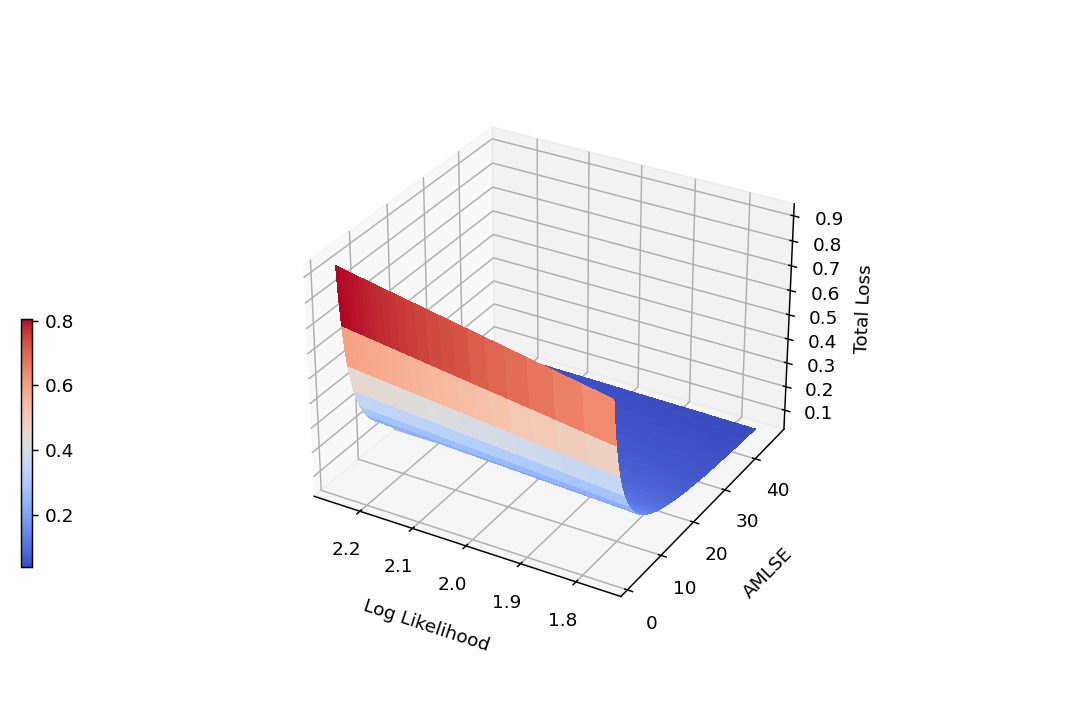

In [127]:
%matplotlib notebook
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=(6,4),subplot_kw={"projection": "3d"})

history = pd.read_csv('history_phat_learning_on_100x_scale.csv')
bodyloss = history.nll
tailloss = history.two_tailed_amlse
X, Y = np.meshgrid(bodyloss, tailloss)
Z = X / (Y + 1)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=5, antialiased=False)

plt.gca().invert_xaxis()

ax.set_xlabel('Log Likelihood', labelpad=10)
ax.set_ylabel('AMLSE', labelpad=10)
ax.set_zlabel('Total Loss')

cax = fig.add_axes([0.02, .2, 0.01, 0.35])
fig.colorbar(surf, cax=cax, orientation='vertical')

plt.show()